# Paper Plots

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import interp1d

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams.update({'mathtext.default': 'regular' })

In [3]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


## Read Data

In [4]:
# List to store all DataFrames
dfs = []

folder_path = '../results/round_metrics'

# Loop through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith('.csv'):  # Ensure it's a CSV file
        file_path = os.path.join(folder_path, file)
        # Load the CSV file into a DataFrame and append it to the list
        dfs.append(pd.read_csv(file_path, index_col=0))

In [5]:
df =  pd.concat(dfs, ignore_index=True)

In [6]:
df['accuracy'] = 100 * df['accuracy'].round(4)
df['accuracy_m'] = 100 * df['accuracy_m'].round(4)
df['accuracy_mm'] = 100 * df['accuracy_mm'].round(4)
df['f1'] = 100 * df['f1'].round(4)
df['matthews_correlation'] = 100 * df['matthews_correlation'].round(4)

In [7]:
df['server_opt_lr_log10'] = np.log10(df['server_opt_lr']).round(1)
df['client_opt_lr_log10'] = np.log10(df['client_opt_lr']).round(1)

In [8]:
df_fedopt = df[~df['fda']].copy()

In [9]:
df_fedopt.loc[:, 'E'] = df_fedopt['local_epochs'].apply(lambda x: int(x))

In [10]:
df_fdaopt = df[df['fda']].copy()

In [11]:
df_fdaopt.loc[:, 'E'] = ((df_fdaopt['max_epochs'] - 8) / 2).apply(lambda x: int(x))

In [12]:
best_performing = {
    ('MRPC', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    ('MRPC', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('MRPC', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('MRPC', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5},
    ('MRPC', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5},
    
    ('RTE', 'FedAdam'): {'server_opt_lr_log10': -5, 'client_opt_lr_log10': -5},
    ('RTE', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('RTE', 'FedAvgM'): {'server_opt_lr_log10': -1, 'client_opt_lr_log10': -3},
    ('RTE', 'FedAdamW'): {'server_opt_lr_log10': -5, 'client_opt_lr_log10': -5},
    ('RTE', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
    
    ('CoLA', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5},
    ('CoLA', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('CoLA', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -5},
    ('CoLA', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
    ('CoLA', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -5},
    
    ('SST-2', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    ('SST-2', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('SST-2', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -4},
    ('SST-2', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    ('SST-2', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    
    ('QNLI', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
    ('QNLI', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('QNLI', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('QNLI', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
    ('QNLI', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -3},
}

In [13]:
best_performing_deberta = {
    ('MNLI', 'FedAdam'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -2},
    ('MNLI', 'FedAvg'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -2},
    ('MNLI', 'FedAvgM'): {'server_opt_lr_log10': 0, 'client_opt_lr_log10': -3},
    ('MNLI', 'FedAdamW'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -4},
    ('MNLI', 'FedAdaGrad'): {'server_opt_lr_log10': -4, 'client_opt_lr_log10': -2},
}

## Functions

In [14]:
def filter_unique_test(df, checkpoint, ds_path, ds_name, alpha, batch_size, num_clients, clients_per_round, fda):
    return df[
        (df['checkpoint'] == checkpoint) &
        (df['ds_path'] == ds_path) &
        (df['ds_name'] == ds_name) &
        (df['alpha'] == alpha) &
        (df['batch_size'] == batch_size) &
        (df['num_clients'] == num_clients) &
        (df['clients_per_round'] == clients_per_round) &
        (df['fda'] == fda)
    ]

In [15]:
def filter_opt(df, algo):
    if algo == 'FedAdam':
        return df[
            (df['server_opt_name'] == 'Adam') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvg':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'].isna())
        ]
    if algo =='FedYogi':
        return df[
            (df['server_opt_name'] == 'Yogi') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAvgM':
        return df[
            (df['server_opt_name'] == 'SGD') &
            (df['client_opt_name'] == 'SGD') &
            (df['server_opt_momentum'] == 0.9)
        ]
    if algo == 'FedAdaGrad':
        return df[
            (df['server_opt_name'] == 'Adagrad') &
            (df['client_opt_name'] == 'SGD')
        ]
    if algo == 'FedAdamW':
        return df[
            (df['server_opt_name'] == 'AdamW') &
            (df['client_opt_name'] == 'SGD')
        ]

In [16]:
def learning_rate_grid_max(df, algo, ds_name, metric):
    
    df_algo = filter_opt(df, algo)
    
    df_algo = df_algo[df_algo['E'] == 1]
    
    column_metric = metric.lower().replace(' ', '_')
    # Group by the specified columns and use a custom aggregation to find the first max based on smallest 'round'
    df_algo_round = (
        df_algo.sort_values([column_metric, 'round'], ascending=[False, True])  # Sort by accuracy descending, then round ascending
        .groupby(['client_opt_lr_log10', 'server_opt_lr_log10'], as_index=False)
        .first()  # Select the first row in each group
    )
    #print(df_algo_round)
    
    
    # Pivot the DataFrame for easier plotting
    pivot_table = df_algo_round.pivot(index='client_opt_lr_log10', columns='server_opt_lr_log10', values=column_metric)

    # Extract unique learning rates and accuracy values
    client_opt_lr = pivot_table.index.astype(float)
    server_opt_lr = pivot_table.columns.astype(float)
    accuracy = pivot_table.values



    # Compute grid edges (midpoints)
    client_opt_lr_edges = []
    server_opt_lr_edges = []

    for axes_val in client_opt_lr:
        client_opt_lr_edges.append(axes_val - 0.5)
        client_opt_lr_edges.append(axes_val + 0.5)

    for axes_val in server_opt_lr:
        server_opt_lr_edges.append(axes_val - 0.5)
        server_opt_lr_edges.append(axes_val + 0.5)

    client_opt_lr_edges = sorted(list(set(client_opt_lr_edges)))
    server_opt_lr_edges = sorted(list(set(server_opt_lr_edges)))
    
    pdf = PdfPages(f'plots/max_{ds_name}_{algo}.pdf')

    # Create the plot
    #plt.figure(figsize=(7, 7))
    plt.figure(figsize=(6.4, 5.5))
    """ For fdaavg
    plt.figure(figsize=(3.2, 7))
    """
    
    # Add accuracy numbers inside the boxes
    for i in range(len(client_opt_lr)):
        for j in range(len(server_opt_lr)):
            plt.text(
                server_opt_lr[j],  # X-coordinate (server learning rate)
                client_opt_lr[i],  # Y-coordinate (client learning rate)
                f"{accuracy[i, j]:.1f}",  # Format the accuracy to 2 decimal places
                ha='center', va='center', color='black', fontsize=20  # Center the text and use a contrasting color
            )

    # Use pcolormesh with the adjusted edges
    mesh = plt.pcolormesh(
        server_opt_lr_edges,  # Server learning rate edges
        client_opt_lr_edges,  # Client learning rate edges
        accuracy,             # Accuracy values
        cmap='Blues',
        #vmin=30,
        #vmax=90
    )
    
    
    
    """ For fdaavg
    plt.gca().set_aspect(1.2)  # Increase this value to make the plot narrower
    # Reduce whitespace around the plot
    plt.subplots_adjust(left=0.1, right=0.65)
    """
    
    plt.subplots_adjust(left=0.15, right=0.95, top=0.92, bottom=0.15)
    


    # Add color bar
    cbar = plt.colorbar(mesh)
    cbar.set_label(metric)

    # Label the axes
    plt.xlabel('Server Learning Rate ($\log_{10}$)')
    plt.ylabel('Client Learning Rate ($\log_{10}$)')
    #plt.title(f'{ds_name}, {algo}')
    plt.title(f'{algo}', fontsize=26)
    
    """for fdaavg
    plt.xticks([])
    """
    plt.xticks(server_opt_lr)
    plt.yticks(client_opt_lr)

    # Show the plot
    #plt.show()
    
    pdf.savefig(plt.gcf()) # Save the current figure
    # Show the plot
    plt.show()
    plt.close()
    pdf.close()

In [17]:
def fda_name(fed_opt):
    if fed_opt == 'FedAdam':
        return 'FDA-Adam'
    if fed_opt == 'FedAvg':
        return 'FDA-SGD'
    if fed_opt == 'FedAvgM':
        return 'FDA-SGDM'
    if fed_opt == 'FedAdaGrad':
        return 'FDA-Adagrad'
    if fed_opt == 'FedAdamW':
        return 'FDA-AdamW'
    
    if fed_opt == 'FedYogi':
        return 'FDA-Yogi'

In [18]:
def plot_all_variance(df, ds_name, every=10):
    pdf = PdfPages(f'plots/var_{ds_name}.pdf')
    
    # Create the plot
    #plt.figure(figsize=(10, 6))
    plt.figure(figsize=(10, 3.2))
    
    markers = ['o', 's', 'D', '^', 'v']
    
    for i, alg in enumerate(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']):
        
        df_alg = filter_opt(df, alg)
        df_alg = df_alg[df_alg['E'] == 1]
        df_alg = df_alg[
            (df_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
            (df_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
        ]
    
        plt.plot(df_alg['round'], df_alg['variance'], marker=markers[i], markersize=8, markevery=every, linestyle='-', label=alg)

    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)

    # Label the axes
    plt.xlabel('Round')
    plt.ylabel('Model Variance')

    plt.yscale('log')

    # Add a title
    #plt.title(algo)
    #plt.tight_layout()
    
    plt.subplots_adjust(top=0.95, bottom=0.21)
    
    plt.yticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

    # Add a legend
    plt.legend(ncol=3, fontsize=13)
    
    #plt.show()

    pdf.savefig(plt.gcf()) # Save the current figure
    plt.show()
    plt.close()
    pdf.close()

In [19]:
def training_loss(df_fda, df_fed, ds_name, every=10):

    markers = ['o', 's', 'D', '^', 'v']

    for i, alg in enumerate(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']):
        
        # Create the plot
        #plt.figure(figsize=(10, 6))
        plt.figure(figsize=(10, 6))

        df_alg_fed = filter_opt(df_fed, alg)
        df_alg_fda = filter_opt(df_fda, alg)

        df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
        df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]
        
        df_alg_fed = df_alg_fed[
            (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
            (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
        ]
        
        df_alg_fda = df_alg_fda[
            (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
            (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
        ]
        

        #plt.plot(df_alg_fed['round'], df_alg_fed['testing_loss'], marker='o', markevery=every, linestyle='-', label=f'{alg} Validation Loss', color='red')
        plt.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, linestyle='-', label=alg, color='red')
        
        fda_alg = alg.replace('Fed', 'FDA-')
        fda_alg = fda_alg.replace('AvgM', 'SGDM')
        fda_alg = fda_alg.replace('Avg', 'SGD')
        #plt.plot(df_alg_fda['round'], df_alg_fda['testing_loss'], marker='o', markevery=every, linestyle='-', label=f'{fda_alg} Validation Loss', color='green')
        plt.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, linestyle='-', label=fda_alg, color='green')

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.6)

        # Label the axes
        plt.xlabel('Round')
        plt.ylabel('Training Loss')

        plt.yscale('log')
        
        """ For fdaavg
        plt.gca().set_aspect(1.2)  # Increase this value to make the plot narrower
        # Reduce whitespace around the plot
        plt.subplots_adjust(left=0.1, right=0.65)
        """
        #plt.gca().set_aspect(50)

        # Add a title
        #plt.title(algo)
        #plt.tight_layout()

        #plt.subplots_adjust(top=0.95, bottom=0.14)

        # Add a legend
        plt.legend()
        plt.show()
        plt.close()

In [20]:
df_fedopt_tmp = df_fedopt.copy()
df_fdaopt_tmp = df_fdaopt.copy() 

# RoBERTa

In [79]:
df_fedopt = df_fedopt_tmp[df_fedopt_tmp['checkpoint'] == 'roberta-base']
df_fdaopt = df_fdaopt_tmp[df_fdaopt_tmp['checkpoint'] == 'roberta-base']

## MRPC

clients = 10, per round = 10, max rounds = 100

In [102]:
best_accuracy = 90.2

In [103]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='roberta-base', ds_path='glue', ds_name='mrpc', alpha=1., batch_size=8, num_clients=10, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='roberta-base', ds_path='glue', ds_name='mrpc', alpha=1., batch_size=8, num_clients=10, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 100]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 100]

In [104]:
ds_name = 'MRPC'
metric = 'Accuracy'
algo = 'FedAvg'
    
df_algo = filter_opt(df_fed_opt, algo)

df_algo = df_algo[df_algo['local_epochs'] == 1]

column_metric = metric.lower().replace(' ', '_')
# Group by the specified columns and use a custom aggregation to find the first max based on smallest 'round'
df_algo_round = (
    df_algo.sort_values([column_metric, 'round'], ascending=[False, True])  # Sort by accuracy descending, then round ascending
    .groupby(['client_opt_lr_log10', 'server_opt_lr_log10'], as_index=False)
    .first()  # Select the first row in each group
)
#print(df_algo_round)


# Pivot the DataFrame for easier plotting
pivot_table = df_algo_round.pivot(index='client_opt_lr_log10', columns='server_opt_lr_log10', values=column_metric)

# Extract unique learning rates and accuracy values
client_opt_lr = pivot_table.index.astype(float)
server_opt_lr = pivot_table.columns.astype(float)
accuracy = pivot_table.values



# Compute grid edges (midpoints)
client_opt_lr_edges = []
server_opt_lr_edges = []

for axes_val in client_opt_lr:
    client_opt_lr_edges.append(axes_val - 0.5)
    client_opt_lr_edges.append(axes_val + 0.5)

for axes_val in server_opt_lr:
    server_opt_lr_edges.append(axes_val - 0.5)
    server_opt_lr_edges.append(axes_val + 0.5)

client_opt_lr_edges = sorted(list(set(client_opt_lr_edges)))
server_opt_lr_edges = sorted(list(set(server_opt_lr_edges)))

pdf = PdfPages(f'plots/max_{ds_name}_{algo}.pdf')

# Create the plot
#plt.figure(figsize=(7, 7))
plt.figure(figsize=(2.7, 5.5))
""" For fdaavg
plt.figure(figsize=(3.2, 7))
"""

# Add accuracy numbers inside the boxes
for i in range(len(client_opt_lr)):
    for j in range(len(server_opt_lr)):
        plt.text(
            server_opt_lr[j],  # X-coordinate (server learning rate)
            client_opt_lr[i],  # Y-coordinate (client learning rate)
            f"{accuracy[i, j]:.1f}",  # Format the accuracy to 2 decimal places
            ha='center', va='center', color='black', fontsize=20  # Center the text and use a contrasting color
        )

# Use pcolormesh with the adjusted edges
mesh = plt.pcolormesh(
    server_opt_lr_edges,  # Server learning rate edges
    client_opt_lr_edges,  # Client learning rate edges
    accuracy,             # Accuracy values
    cmap='Blues',
    #vmin=30,
    #vmax=90
)



""" For fdaavg
plt.gca().set_aspect(1.2)  # Increase this value to make the plot narrower
# Reduce whitespace around the plot
plt.subplots_adjust(left=0.1, right=0.65)
"""

plt.subplots_adjust(left=0.35, right=0.7, top=0.92, bottom=0.15)



# Add color bar
cbar = plt.colorbar(mesh)
cbar.set_label(metric)

# Label the axes
#plt.xlabel('Server Learning Rate ($\log_{10}$)')
plt.ylabel('Client Learning Rate ($\log_{10}$)')
#plt.title(f'{ds_name}, {algo}')
plt.title(f'{algo}', fontsize=26)


plt.xticks([])

plt.xticks(server_opt_lr)
plt.yticks(client_opt_lr)

# Show the plot
#plt.show()

pdf.savefig(plt.gcf()) # Save the current figure
plt.close()
pdf.close()

### Variance

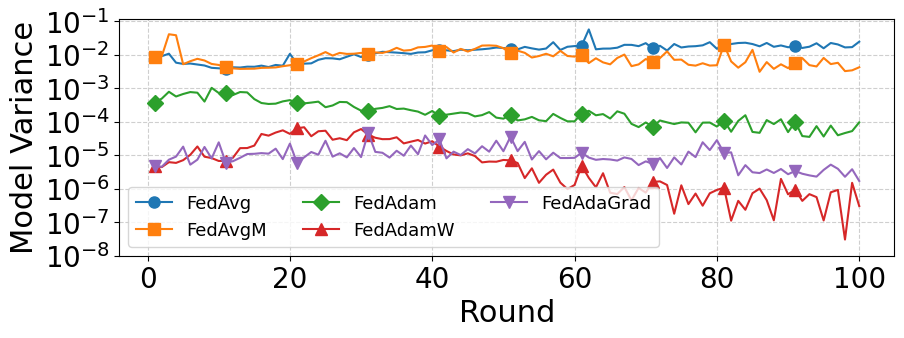

In [105]:
plot_all_variance(df_fed_opt, 'MRPC')

### Training loss

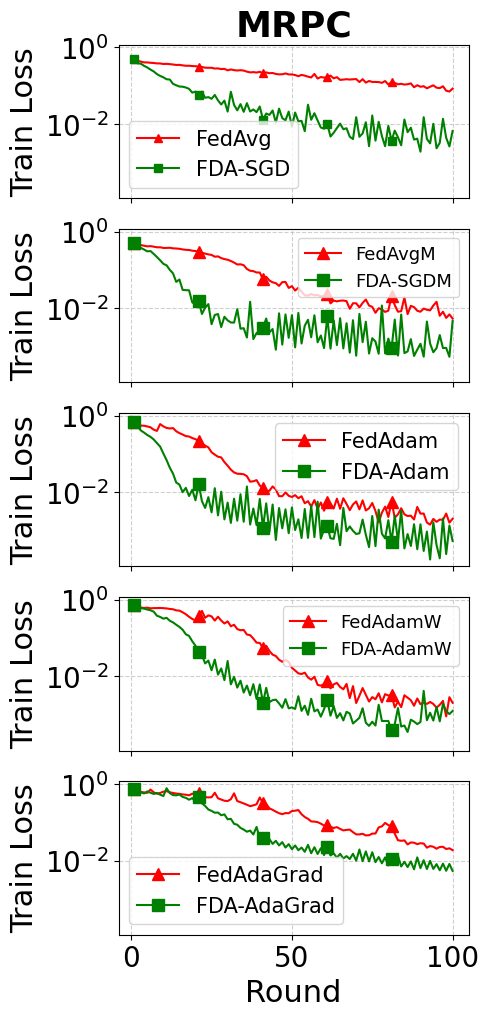

In [106]:
df_fda = df_fda_opt.copy()
df_fed = df_fed_opt.copy()
ds_name = 'MRPC'
every = 20
markersize=8
    
pdf = PdfPages(f'plots/train_loss_{ds_name}.pdf')

algorithms = ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']

# Create a single figure with subplots
#fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 15), sharex=True, sharey=True)
fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 10), sharex=True, sharey=True)


# --------------- FedAvg ------------------------------------
i = 0
alg = 'FedAvg'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

ax.set_title('MRPC', fontsize=26)

# --------------- FedAvgM ------------------------------------
i = 1
alg = 'FedAvgM'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every,markersize=markersize,  linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=13)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')


# --------------- FedAdam ------------------------------------
i = 2
alg = 'FedAdam'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

# --------------- FedAdamW ------------------------------------
i = 3
alg = 'FedAdamW'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=13)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

# --------------- FedAdaGrad ------------------------------------
i = 4
alg = 'FedAdaGrad'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

plt.subplots_adjust(left=0.25, top=0.96, bottom=0.07, right=0.95)



# Label the axes
plt.xlabel('Round')
#plt.ylabel('Training Loss')



pdf.savefig(plt.gcf()) # Save the current figure
plt.show()
plt.close()
pdf.close()

### Table: FDA vs Fed-Opt

In [107]:
percentages = [0.85, 0.9, 0.95]

In [108]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('MRPC', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('MRPC', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('MRPC', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('MRPC', alg)]['client_opt_lr_log10'])
    ]
    
    fed_opt_row = [f"{alg} (e = 1)"]

    df_e = df_fed_alg[df_fed_alg['E'] == 1]

    #print(len(df_fed_alg))

    for perc in percentages:
        acc = perc * best_accuracy
        def_fed_alg_best = df_e[df_e['accuracy'] >= acc]

        if def_fed_alg_best.empty:
            fed_opt_row.append(np.NaN)
        else:
            fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])

    table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    df_e = df_fda_alg[df_fda_alg['E'] == 1]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_e[df_e['accuracy'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

,Algorithm,0.85,0.9,0.95
0,FedAvg (e = 1),19,26,30
1,FDA-SGD,5,6,10
2,#,#,#,#
3,FedAvgM (e = 1),17,21,31
4,FDA-SGDM,5,5,16
5,#,#,#,#
6,FedAdam (e = 1),17,20,40
7,FDA-Adam,5,7,11
8,#,#,#,#
9,FedAdamW (e = 1),16,17,25


In [109]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [110]:
speedup_tab

,Information,0.85,0.9,0.95
0,FDA-SGD Speedup,3.8,4.333333,3.0
1,FDA-SGDM Speedup,3.4,4.2,1.9375
2,FDA-Adam Speedup,3.4,2.857143,3.636364
3,FDA-AdamW Speedup,2.285714,1.214286,1.5625
4,FDA-Adagrad Speedup,1.588235,1.380952,1.521739
5,Average Speedup,2.89479,2.797143,2.331621


### Varying E

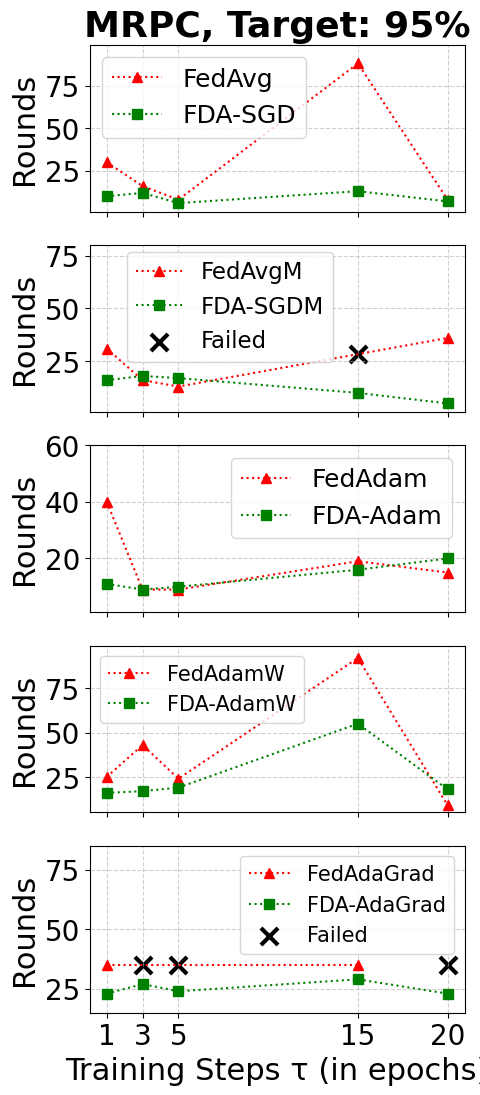

In [113]:
df_fda = df_fda_opt.copy()
df_fed = df_fed_opt.copy()
ds_name = 'MRPC'
close = 0.95
    
pdf = PdfPages(f'plots/{ds_name}_E.pdf')

algorithms = ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']

# Create a single figure with subplots
fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 11), sharex=True)


# --------------- FedAvg ------------------------------------

for i, (alg, fda_alg) in enumerate(zip(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad'], ['FDA-SGD', 'FDA-SGDM', 'FDA-Adam', 'FDA-AdamW', 'FDA-AdaGrad'])):

    ax = axes[i]

    df_fed_alg = filter_opt(df_fed, alg)
    df_fda_alg = filter_opt(df_fda, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
    ]

    #fdaopt_E = sorted(list(df_fda_alg['E'].unique()))
    fdaopt_E = [1, 3, 5, 15, 20]
    fdaopt_R = []

    #fedopt_E = sorted(list(df_fed_alg['E'].unique()))
    fedopt_E = [1, 3, 5, 15, 20] 
    fedopt_R = []

    #print(df_fed_alg['E'].unique())

    #for e in sorted(df_fed_alg['E'].unique()):
    for E in fedopt_E:

        df_e = df_fed_alg[df_fed_alg['E'] == E]

        def_fed_alg_best = df_e[df_e['accuracy'] >= best_accuracy * close]

        if def_fed_alg_best.empty:
            fedopt_R.append(np.NaN)
        else:
            fedopt_R.append(def_fed_alg_best.iloc[0]['round'])

    for E in fdaopt_E:

        df_e = df_fda_alg[df_fda_alg['E'] == E]

        def_fda_alg_best = df_e[df_e['accuracy'] >= best_accuracy * close]

        if def_fda_alg_best.empty:
            fdaopt_R.append(np.NaN)
        else:
            fdaopt_R.append(def_fda_alg_best.iloc[0]['round'])

    #fedopt_R_interpolated = pd.Series(fedopt_R).interpolate(limit=1, method='linear', limit_direction='both').tolist()
    fedopt_interpolated_indices = [i for i, r in enumerate(fedopt_R) if np.isnan(r)]
    fedopt_E_clean = [e for e, r in zip(fedopt_E, fedopt_R) if not np.isnan(r)]
    fedopt_R_clean = [r for r in fedopt_R if not np.isnan(r)]
    
    # Create interpolation function using only valid values
    interp_func = interp1d(fedopt_E_clean, fedopt_R_clean, kind='linear', fill_value='extrapolate')
    # Perform interpolation for all x values
    fedopt_R_interpolated = interp_func(fedopt_E)

    ax.plot(fedopt_E_clean, fedopt_R_clean, marker='^', markersize=7, linestyle=':', label=alg, color='red')
    ax.plot(fdaopt_E, fdaopt_R, marker='s', markersize=7, linestyle=':', label=fda_alg, color='green')

    if fedopt_interpolated_indices:
        ax.scatter(
            [fedopt_E[i] for i in fedopt_interpolated_indices],
            [fedopt_R_interpolated[i] for i in fedopt_interpolated_indices],
            marker='x',
            s=150,
            color='black',
            label='Failed',
            linewidths=3
        )

    ax.set_ylabel('Rounds')
    ax.set_xticks(fdaopt_E)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    #ax.set_ylim([0, 100])
    if alg == 'FedAvg':
        ax.legend(loc='upper left')
        ax.set_ylim([1, 99])
    if alg == 'FedAvgM':
        ax.set_ylim([1, 80])
        ax.legend(loc=[0.1, 0.3], fontsize=16.5)
    if alg == 'FedAdam':
        #ax.legend(loc='upper center')
        ax.set_ylim([1, 60])
    if alg == 'FedAdamW':
        #ax.legend(loc='upper center')
        ax.legend(fontsize=15)
        ax.set_ylim([5, 99])
    if alg == 'FedAdaGrad':
        #ax.legend(loc='upper center')
        ax.set_ylim([15, 85])
        ax.legend(fontsize=15)

    if i == 0:
        ax.set_title("MRPC, Target: 95%", fontsize=26)



plt.xlabel('Training Steps τ (in epochs)')


#plt.show()
plt.subplots_adjust(left=0.2, top=0.95, bottom=0.07, right=0.95)


pdf.savefig(plt.gcf()) # Save the current figure
plt.show()
plt.close()
pdf.close()
#plt.show()

## RTE

clients = 10, per round = 5, max rounds = 250

In [39]:
best_accuracy = 78.7

In [40]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='roberta-base', ds_path='glue', ds_name='rte', alpha=1., batch_size=8, num_clients=10, clients_per_round=5, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='roberta-base', ds_path='glue', ds_name='rte', alpha=1., batch_size=8, num_clients=10, clients_per_round=5, fda=True
)

### Table: FDA vs Fed-Opt

In [41]:
percentages = [0.85, 0.9, 0.95]

In [42]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('RTE', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('RTE', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('RTE', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('RTE', alg)]['client_opt_lr_log10'])
    ]
    


    fed_opt_row = [f"{alg} (e = 1)"]

    df_e = df_fed_alg[df_fed_alg['E'] == 1]

    #print(len(df_fed_alg))

    for perc in percentages:
        acc = perc * best_accuracy
        def_fed_alg_best = df_e[df_e['accuracy'] >= acc]

        if def_fed_alg_best.empty:
            fed_opt_row.append(np.NaN)
        else:
            fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])

    table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    df_e = df_fda_alg[df_fda_alg['E'] == 1]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_e[df_e['accuracy'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

,Algorithm,0.85,0.9,0.95
0,FedAvg (e = 1),50,67,103
1,FDA-SGD,13,16,20
2,#,#,#,#
3,FedAvgM (e = 1),73,111,182
4,FDA-SGDM,25,41,126
5,#,#,#,#
6,FedAdam (e = 1),93,118,153
7,FDA-Adam,61,72,188
8,#,#,#,#
9,FedAdamW (e = 1),94,118,160


In [43]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [44]:
speedup_tab

,Information,0.85,0.9,0.95
0,FDA-SGD Speedup,3.846154,4.1875,5.15
1,FDA-SGDM Speedup,2.92,2.707317,1.444444
2,FDA-Adam Speedup,1.52459,1.638889,0.81383
3,FDA-AdamW Speedup,1.540984,1.661972,0.909091
4,FDA-Adagrad Speedup,2.8,1.111111,1.777778
5,Average Speedup,2.526346,2.261358,2.019029


## SST-2

clients = 100, per round = 10, max rounds = 200

In [114]:
best_accuracy = 94.8

In [115]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='roberta-base', ds_path='glue', ds_name='sst2', alpha=1., batch_size=8, num_clients=100, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='roberta-base', ds_path='glue', ds_name='sst2', alpha=1., batch_size=8, num_clients=100, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 200]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 200]

### Training Loss

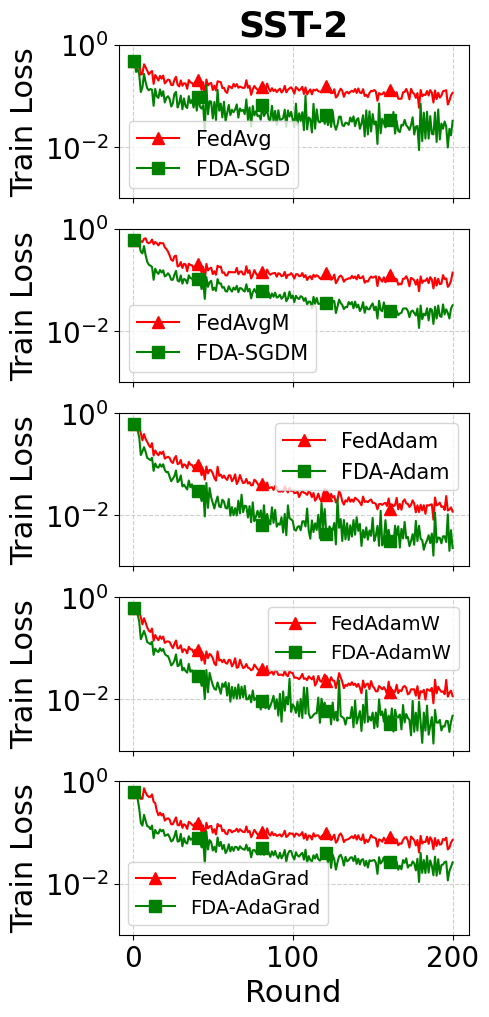

In [116]:
df_fda = df_fda_opt.copy()
df_fed = df_fed_opt.copy()
ds_name = 'SST-2'
every = 40

markersize=8
    
pdf = PdfPages(f'plots/train_loss_{ds_name}.pdf')

algorithms = ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']

# Create a single figure with subplots
fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 10), sharex=True, sharey=True)


# --------------- FedAvg ------------------------------------
i = 0
alg = 'FedAvg'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

ax.set_title(ds_name, fontsize=26)

# --------------- FedAvgM ------------------------------------
i = 1
alg = 'FedAvgM'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')


# --------------- FedAdam ------------------------------------
i = 2
alg = 'FedAdam'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=15)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

# --------------- FedAdamW ------------------------------------
i = 3
alg = 'FedAdamW'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

# --------------- FedAdaGrad ------------------------------------
i = 4
alg = 'FedAdaGrad'

ax = axes[i]

# Filter data for the current algorithm
df_alg_fed = filter_opt(df_fed, alg)
df_alg_fda = filter_opt(df_fda, alg)

df_alg_fed = df_alg_fed[df_alg_fed['E'] == 1]
df_alg_fda = df_alg_fda[df_alg_fda['E'] == 1]

df_alg_fed = df_alg_fed[
    (df_alg_fed['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fed['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

df_alg_fda = df_alg_fda[
    (df_alg_fda['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
    (df_alg_fda['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
]

# Plot FedOpt
ax.plot(df_alg_fed['round'], df_alg_fed['training_loss'], marker='^', markevery=every, markersize=markersize, linestyle='-', label=alg, color='red')

# Plot FDA-Opt
fda_alg = alg.replace('Fed', 'FDA-')
fda_alg = fda_alg.replace('AvgM', 'SGDM')
fda_alg = fda_alg.replace('Avg', 'SGD')
ax.plot(df_alg_fda['round'], df_alg_fda['training_loss'], marker='s', markevery=every, markersize=markersize, linestyle='-', label=fda_alg, color='green')

# Add grid and legend for each subplot
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(fontsize=14)
ax.set_yscale('log')
ax.set_ylabel('Train Loss')

plt.subplots_adjust(left=0.25, top=0.96, bottom=0.07, right=0.95)



# Label the axes
plt.xlabel('Round')
#plt.ylabel('Training Loss')

# Adjust layout to save space
#plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust spacing

pdf.savefig(plt.gcf()) # Save the current figure
plt.show()
plt.close()
pdf.close()
#plt.show()

### Table: FDA vs Fed-Opt

In [117]:
percentages = [0.9, 0.95, 0.99]

In [118]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('SST-2', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('SST-2', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('SST-2', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('SST-2', alg)]['client_opt_lr_log10'])
    ]

    fed_opt_row = [f"{alg} (e = 1)"]

    df_e = df_fed_alg[df_fed_alg['E'] == 1]

    #print(len(df_fed_alg))

    for perc in percentages:
        acc = perc * best_accuracy
        def_fed_alg_best = df_e[df_e['accuracy'] >= acc]

        if def_fed_alg_best.empty:
            fed_opt_row.append(np.NaN)
        else:
            fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])

    table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    df_e = df_fda_alg[df_fda_alg['E'] == 1]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_e[df_e['accuracy'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

,Algorithm,0.9,0.95,0.99
0,FedAvg (e = 1),8,8,93
1,FDA-SGD,3,7,43
2,#,#,#,#
3,FedAvgM (e = 1),23,30,91
4,FDA-SGDM,8,12,41
5,#,#,#,#
6,FedAdam (e = 1),7,12,42
7,FDA-Adam,4,8,25
8,#,#,#,#
9,FedAdamW (e = 1),7,12,35


In [119]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

In [120]:
speedup_tab

,Information,0.9,0.95,0.99
0,FDA-SGD Speedup,2.666667,1.142857,2.162791
1,FDA-SGDM Speedup,2.875,2.5,2.219512
2,FDA-Adam Speedup,1.75,1.5,1.68
3,FDA-AdamW Speedup,1.75,1.5,2.5
4,FDA-Adagrad Speedup,2.142857,3.0,2.791667
5,Average Speedup,2.236905,1.928571,2.270794


### Varying E

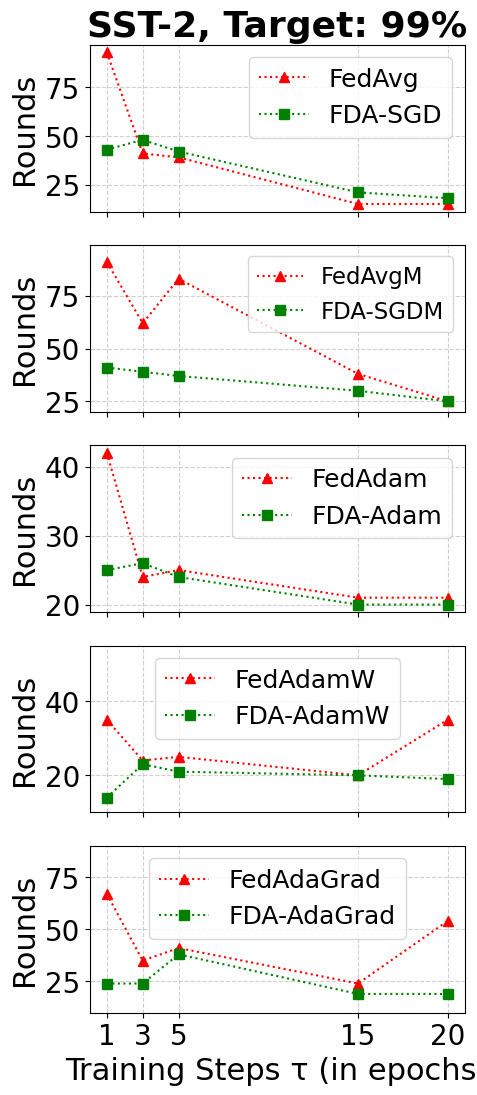

In [122]:
df_fda = df_fda_opt.copy()
df_fed = df_fed_opt.copy()
ds_name = 'SST-2'
close = 0.99
    
pdf = PdfPages(f'plots/{ds_name}_E.pdf')

algorithms = ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']

# Create a single figure with subplots
fig, axes = plt.subplots(len(algorithms), 1, figsize=(5, 11), sharex=True)


# --------------- FedAvg ------------------------------------

for i, (alg, fda_alg) in enumerate(zip(['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad'], ['FDA-SGD', 'FDA-SGDM', 'FDA-Adam', 'FDA-AdamW', 'FDA-AdaGrad'])):

    ax = axes[i]

    df_fed_alg = filter_opt(df_fed, alg)
    df_fda_alg = filter_opt(df_fda, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[(ds_name, alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[(ds_name, alg)]['client_opt_lr_log10'])
    ]

    #fdaopt_E = sorted(list(df_fda_alg['E'].unique()))
    fdaopt_E = [1, 3, 5, 15, 20]
    fdaopt_R = []

    #fedopt_E = sorted(list(df_fed_alg['E'].unique()))
    fedopt_E = [1, 3, 5, 15, 20] 
    fedopt_R = []

    #print(df_fed_alg['E'].unique())

    #for e in sorted(df_fed_alg['E'].unique()):
    for E in fedopt_E:

        df_e = df_fed_alg[df_fed_alg['E'] == E]

        def_fed_alg_best = df_e[df_e['accuracy'] >= best_accuracy * close]

        if def_fed_alg_best.empty:
            fedopt_R.append(np.NaN)
        else:
            fedopt_R.append(def_fed_alg_best.iloc[0]['round'])

    for E in fdaopt_E:

        df_e = df_fda_alg[df_fda_alg['E'] == E]

        def_fda_alg_best = df_e[df_e['accuracy'] >= best_accuracy * close]

        if def_fda_alg_best.empty:
            fdaopt_R.append(np.NaN)
        else:
            fdaopt_R.append(def_fda_alg_best.iloc[0]['round'])

    #fedopt_R_interpolated = pd.Series(fedopt_R).interpolate(limit=1, method='linear', limit_direction='both').tolist()
    fedopt_interpolated_indices = [i for i, r in enumerate(fedopt_R) if np.isnan(r)]
    fedopt_E_clean = [e for e, r in zip(fedopt_E, fedopt_R) if not np.isnan(r)]
    fedopt_R_clean = [r for r in fedopt_R if not np.isnan(r)]
    
    # Create interpolation function using only valid values
    interp_func = interp1d(fedopt_E_clean, fedopt_R_clean, kind='linear', fill_value='extrapolate')
    # Perform interpolation for all x values
    fedopt_R_interpolated = interp_func(fedopt_E)

    ax.plot(fedopt_E_clean, fedopt_R_clean, marker='^', markersize=7, linestyle=':', label=alg, color='red')
    ax.plot(fdaopt_E, fdaopt_R, marker='s', markersize=7, linestyle=':', label=fda_alg, color='green')

    if fedopt_interpolated_indices:
        ax.scatter(
            [fedopt_E[i] for i in fedopt_interpolated_indices],
            [fedopt_R_interpolated[i] for i in fedopt_interpolated_indices],
            marker='x',
            s=150,
            color='black',
            label='Failed',
            linewidths=3
        )

    ax.set_ylabel('Rounds')
    ax.set_xticks(fdaopt_E)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    #ax.set_ylim([0, 100])
    if alg == 'FedAvgM':
        ax.set_ylim([20, 99])
        ax.legend(fontsize=16.5)
    if alg == 'FedAdamW':
        ax.legend(loc='upper center')
        ax.set_ylim([10, 55])
    if alg == 'FedAdaGrad':
        ax.legend(loc='upper center')
        ax.set_ylim([10, 90])

    if i == 0:
        ax.set_title("SST-2, Target: 99%", fontsize=26)




plt.xlabel('Training Steps τ (in epochs)')

#plt.show()
plt.subplots_adjust(left=0.2, top=0.95, bottom=0.07, right=0.95)


pdf.savefig(plt.gcf()) # Save the current figure
plt.show()
plt.close()
pdf.close()
#plt.show()

## QNLI

clients = 250, per round = 10, max rounds = 200

In [101]:
best_accuracy = 92.8

In [60]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='roberta-base', ds_path='glue', ds_name='qnli', alpha=1., batch_size=8, num_clients=250, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='roberta-base', ds_path='glue', ds_name='qnli', alpha=1., batch_size=8, num_clients=250, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 200]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 200]

### Table: FDA vs Fed-Opt

In [61]:
percentages = [0.85, 0.9, 0.95]

In [62]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing[('QNLI', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing[('QNLI', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing[('QNLI', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing[('QNLI', alg)]['client_opt_lr_log10'])
    ]

    fed_opt_row = [f"{alg} (e = 1)"]

    df_e = df_fed_alg[df_fed_alg['E'] == 1]

    #print(len(df_fed_alg))

    for perc in percentages:
        acc = perc * best_accuracy
        def_fed_alg_best = df_e[df_e['accuracy'] >= acc]

        if def_fed_alg_best.empty:
            fed_opt_row.append(np.NaN)
        else:
            fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])

    table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    df_e = df_fda_alg[df_fda_alg['E'] == 1]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_e[df_e['accuracy'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']

table

,Algorithm,0.85,0.9,0.95
0,FedAvg (e = 1),15,35,71
1,FDA-SGD,4,9,23
2,#,#,#,#
3,FedAvgM (e = 1),16,38,81
4,FDA-SGDM,6,11,44
5,#,#,#,#
6,FedAdam (e = 1),6,11,22
7,FDA-Adam,5,6,22
8,#,#,#,#
9,FedAdamW (e = 1),6,11,22


In [63]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

table

,Algorithm,0.85,0.9,0.95
0,FedAvg (e = 1),15,35,71
1,FDA-SGD,4,9,23
2,#,#,#,#
3,FedAvgM (e = 1),16,38,81
4,FDA-SGDM,6,11,44
5,#,#,#,#
6,FedAdam (e = 1),6,11,22
7,FDA-Adam,5,6,22
8,#,#,#,#
9,FedAdamW (e = 1),6,11,22


In [64]:
speedup_tab

,Information,0.85,0.9,0.95
0,FDA-SGD Speedup,3.75,3.888889,3.086957
1,FDA-SGDM Speedup,2.666667,3.454545,1.840909
2,FDA-Adam Speedup,1.2,1.833333,1.0
3,FDA-AdamW Speedup,1.5,1.833333,1.1
4,FDA-Adagrad Speedup,1.25,2.0,1.2
5,Average Speedup,2.073333,2.60202,1.645573


# DeBERTaV3

In [65]:
df_fedopt = df_fedopt_tmp[df_fedopt_tmp['checkpoint'] == 'microsoft/deberta-v3-base']
df_fdaopt = df_fdaopt_tmp[df_fdaopt_tmp['checkpoint'] == 'microsoft/deberta-v3-base']

## MNLI-m

clients = 1000, per round = 10, max rounds = 100

In [66]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='microsoft/deberta-v3-base', ds_path='glue', ds_name='mnli', alpha=1., batch_size=8, num_clients=1000, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='microsoft/deberta-v3-base', ds_path='glue', ds_name='mnli', alpha=1., batch_size=8, num_clients=1000, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 200]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 200]

best_accuracy = 90.6

### Table: FDA vs Fed-Opt

In [67]:
percentages = [0.85, 0.9]

In [68]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['client_opt_lr_log10'])
    ]
    
    e = 1

    fed_opt_row = [f"{alg} (e = {e})"]

    df_e = df_fed_alg[df_fed_alg['E'] == e]

    #print(len(df_fed_alg))

    for perc in percentages:
        acc = perc * best_accuracy
        def_fed_alg_best = df_e[df_e['accuracy_m'] >= acc]

        if def_fed_alg_best.empty:
            fed_opt_row.append(np.NaN)
        else:
            fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])

    table.loc[len(table)] = fed_opt_row

    fda_opt_row = [fda_name(alg)]

    for perc in percentages:
        acc = perc * best_accuracy

        def_fda_alg_best = df_fda_alg[df_fda_alg['accuracy_m'] >= acc]

        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])

    table.loc[len(table)] = fda_opt_row

    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

,Algorithm,0.85,0.9
0,FedAvg (e = 1),12,16
1,FDA-SGD,4,8
2,#,#,#
3,FedAvgM (e = 1),29,35
4,FDA-SGDM,12,15
5,#,#,#
6,FedAdam (e = 1),11,12
7,FDA-Adam,9,10
8,#,#,#
9,FedAdamW (e = 1),57,66


In [69]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

## MNLI-mm

clients = 1000, per round = 10, max rounds = 100

In [70]:
df_fed_opt = filter_unique_test(
    df_fedopt, checkpoint='microsoft/deberta-v3-base', ds_path='glue', ds_name='mnli', alpha=1., batch_size=8, num_clients=1000, clients_per_round=10, fda=False
)
df_fda_opt = filter_unique_test(
    df_fdaopt, checkpoint='microsoft/deberta-v3-base', ds_path='glue', ds_name='mnli', alpha=1., batch_size=8, num_clients=1000, clients_per_round=10, fda=True
)

df_fed_opt = df_fed_opt[df_fed_opt['round'] <= 200]
df_fda_opt = df_fda_opt[df_fda_opt['round'] <= 200]

best_accuracy = 90.7

### Table: FDA vs Fed-Opt

In [71]:
table = pd.DataFrame(columns=["Algorithm", *percentages])

for alg in ['FedAvg', 'FedAvgM', 'FedAdam', 'FedAdamW', 'FedAdaGrad']:

    df_fed_alg = filter_opt(df_fed_opt, alg)
    df_fda_alg = filter_opt(df_fda_opt, alg)

    df_fed_alg = df_fed_alg[
        (df_fed_alg['server_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['server_opt_lr_log10']) & 
        (df_fed_alg['client_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['client_opt_lr_log10'])
    ]

    df_fda_alg = df_fda_alg[
        (df_fda_alg['server_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['server_opt_lr_log10']) & 
        (df_fda_alg['client_opt_lr_log10'] == best_performing_deberta[('MNLI', alg)]['client_opt_lr_log10'])
    ]
    
    #print(df_fed_alg['E'].unique())
    
    #for e in sorted(df_fed_alg['E'].unique()):
    e = 1
        
    fed_opt_row = [f"{alg} (e = {e})"]

    df_e = df_fed_alg[df_fed_alg['E'] == e]

    #print(len(df_fed_alg))

    for perc in percentages:
        acc = perc * best_accuracy
        def_fed_alg_best = df_e[df_e['accuracy_mm'] >= acc]

        if def_fed_alg_best.empty:
            fed_opt_row.append(np.NaN)
        else:
            fed_opt_row.append(def_fed_alg_best.iloc[0]['round'])

    table.loc[len(table)] = fed_opt_row
        
    fda_opt_row = [fda_name(alg)]
    
    for perc in percentages:
        acc = perc * best_accuracy
                
        def_fda_alg_best = df_fda_alg[df_fda_alg['accuracy_mm'] >= acc]
            
        if def_fda_alg_best.empty:
            fda_opt_row.append(np.NaN)
        else:
            fda_opt_row.append(def_fda_alg_best.iloc[0]['round'])
    
    table.loc[len(table)] = fda_opt_row
    
    table.loc[len(table)] = (len(percentages) + 1) * ['#']
    
table

,Algorithm,0.85,0.9
0,FedAvg (e = 1),12,15
1,FDA-SGD,4,6
2,#,#,#
3,FedAvgM (e = 1),29,35
4,FDA-SGDM,12,15
5,#,#,#
6,FedAdam (e = 1),11,12
7,FDA-Adam,9,10
8,#,#,#
9,FedAdamW (e = 1),57,66


In [73]:
fedopt_tab = table[table['Algorithm'].str.contains(r"\(e = 1\)")]
fdaopt_tab = table[table['Algorithm'].str.contains(r"FDA")]

# Reset indices for pairing
fedopt_tab.reset_index(drop=True, inplace=True)
fdaopt_tab.reset_index(drop=True, inplace=True)

speedup_tab = pd.DataFrame(columns=["Information", *percentages])

speedup_tab["Information"] = fdaopt_tab["Algorithm"] + " Speedup"

for perc in percentages:
    speedup_tab[perc] = fedopt_tab[perc] / fdaopt_tab[perc]
    
average_row = ["Average Speedup"]
for perc in percentages:
    average_row.append(speedup_tab[perc].mean())

speedup_tab.loc[len(speedup_tab)] = average_row

speedup_tab

,Information,0.85,0.9
0,FDA-SGD Speedup,3.0,2.5
1,FDA-SGDM Speedup,2.416667,2.333333
2,FDA-Adam Speedup,1.222222,1.2
3,FDA-AdamW Speedup,1.357143,1.269231
4,FDA-Adagrad Speedup,1.333333,0.785714
5,Average Speedup,1.865873,1.617656


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams['font.size'] = 14.0
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'

### Funcs

In [62]:
from datasets import load_dataset
import numpy as np
import random

def calculate_prior_distribution(raw_train_dataset):
    """
    Calculate the prior distribution of labels in the training dataset.

    This function calculates the proportion of each label in the training dataset,
    which is used as the prior distribution for Dirichlet sampling.

    Args:
        raw_train_dataset (datasets.arrow_dataset.Dataset): The training dataset.

    Returns:
        tuple: A tuple containing:
            - prior_distribution (numpy.ndarray): An array of label proportions.
            - num_labels (int): The number of unique labels in the dataset.
    """

    # Calculate the number of samples for each label
    label_count_dict = dict(raw_train_dataset.to_pandas()['label'].value_counts())
    # Num. of samples
    n = len(raw_train_dataset)
    # (label, count) list, sorted with label increasing
    label_count_tuple = sorted(label_count_dict.items(), key=lambda x: x[0])
    # prior distribution
    prior_distribution = np.array([c / n for _, c in label_count_tuple])

    # number of labels
    num_labels = len(label_count_dict)

    return prior_distribution, num_labels


def sample_to_client(client_sample_counts, sample_label):
    """
    Assign a sample to a client based on the sample's label and the remaining counts for each client.

    This function assigns a sample to the client that still needs more samples of the given label.
    It decrements the count for that label for the chosen client. If no client has a remaining count
    of at least 1 for the label, the function assigns the sample to the client with the largest leftover count
    for that label.

    Args:
        client_sample_counts (numpy.ndarray): A 2D array where each row corresponds to a client and each column corresponds
            to the count (float) of samples needed for each label. The element at (i, j) represents the decimal number of
            samples of label j that client i still needs.
        sample_label (int): The label of the sample to be assigned to a client.

    Returns:
        int: The index of the client to which the sample has been assigned.
    """
    num_clients = len(client_sample_counts)
    client_indices = np.random.permutation(num_clients)

    for client_idx in client_indices:
        client_sample_count = client_sample_counts[client_idx]

        if client_sample_count[sample_label] >= 1:
            client_sample_count[sample_label] -= 1

            return client_idx

    # if all client data counts are less than 1, then assign the sample to the largest leftover
    client_idx = np.argmax(client_sample_counts[:, sample_label])
    client_sample_counts[client_idx][sample_label] -= 1

    return client_idx


def federated_dirichlet_datasets(raw_train_dataset, prior_distribution, num_clients, alpha):
    """
    Create federated datasets using Dirichlet-distributed label partitions.

    This function partitions the training dataset into multiple subsets, each corresponding
    to a client. The label distribution for each client is drawn from a Dirichlet distribution
    parameterized by the given prior distribution and concentration parameter alpha.
    The function also aims to keep the datasets as equal in size as possible.

    Args:
        raw_train_dataset (datasets.arrow_dataset.Dataset): The training dataset.
        prior_distribution (numpy.ndarray): An array representing the prior distribution of labels.
        num_clients (int): The number of clients.
        alpha (float): The concentration parameter for the Dirichlet distribution.

    Returns:
        list: A list of `datasets.arrow_dataset.Dataset` objects, each representing a client's dataset.
    """

    # Num. of samples
    n = len(raw_train_dataset)

    client_num_samples = n / num_clients

    # Draw label distributions for each client from Dirichlet distribution
    # Each i-th row represents the distribution of labels for the i-th client
    client_distributions = np.random.dirichlet(alpha * prior_distribution, num_clients)

    # Initialize client data indices
    client_sample_indices = [[] for i in range(num_clients)]

    # Calculate the number of samples per label each client should have
    # client_sample_counts[i] is an array of `num_label` elements
    # -- the counts for each label for the i-th client.
    client_sample_counts = np.array([
        client_distributions[client_idx, :] * client_num_samples
        for client_idx in range(num_clients)
    ])

    for sample_idx, sample in enumerate(raw_train_dataset):
        client_idx = sample_to_client(client_sample_counts, sample['label'])

        client_sample_indices[client_idx].append(sample_idx)

    # Create a Dataset for each client
    client_datasets = []
    for client_indices in client_sample_indices:
        client_dataset = raw_train_dataset.select(client_indices)
        client_datasets.append(client_dataset)

    return client_datasets


def get_label_distribution(dataset):
    label_distr = dataset.features['label'].names
    label_counts = dataset.to_pandas()['label'].value_counts()
    
    label_distr_dict = {label_distr[label]: count for label, count in label_counts.items()}
    return label_distr_dict

/home/mtheologitis/anaconda3/envs/data-analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SST2

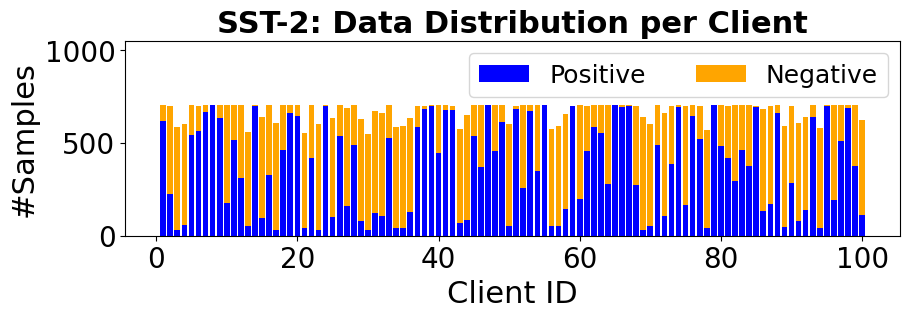

In [63]:
num_clients = 100
alpha = 1.0
name = 'sst2'

np.random.seed(42)
random.seed(42)

# Load the raw dataset
raw_datasets = load_dataset(path='glue', name=name)

# 2. Training dataset
raw_train_dataset = raw_datasets['train']

# Calculate the prior distribution
prior_distribution, num_labels = calculate_prior_distribution(raw_train_dataset)

# Partition the dataset into federated datasets
client_datasets = federated_dirichlet_datasets(raw_train_dataset, prior_distribution, num_clients, alpha)

client_label_distr = [
    get_label_distribution(client_datasets[i]) for i in range(num_clients)
]

# Convert data to a DataFrame for easier manipulation
df = pd.DataFrame(client_label_distr)
df = df.fillna(0)


# Save to PDF
pdf = PdfPages(f'plots/SST2_distribution.pdf')

# Create a stacked bar chart for the label distribution across clients
fig, ax = plt.subplots(figsize=(10, 3))
x = range(1, len(df)+1)
ax.bar(x, df['positive'], label='Positive', color='blue')
ax.bar(x, df['negative'], bottom=df['positive'], label='Negative', color='orange')

# Add labels and title
ax.set_title('SST-2: Data Distribution per Client')
ax.set_xlabel('Client ID')
ax.set_ylabel('#Samples')
ax.legend()
ax.set_ylim(0, 1050)

#ax.set_xlim(0.5, len(df) + 0.5)  # Adjust x-axis to start with 1 but leave space on the left
legend = ax.legend(ncol=2)

# Apply tight layout BEFORE saving
#plt.tight_layout()

plt.subplots_adjust(top=0.88, bottom=0.23)  # Adjust these values as needed

pdf.savefig(plt.gcf()) # Save the current figure
# Display the plot
plt.show()
plt.close()
pdf.close()


## MRPC

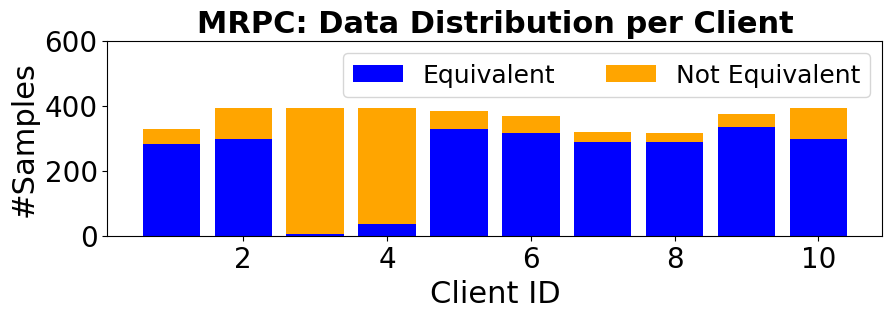

In [64]:
num_clients = 10
alpha = 1.0
name = 'mrpc'

np.random.seed(42)
random.seed(42)

# Load the raw dataset
raw_datasets = load_dataset(path='glue', name=name)

# 2. Training dataset
raw_train_dataset = raw_datasets['train']

# Calculate the prior distribution
prior_distribution, num_labels = calculate_prior_distribution(raw_train_dataset)

# Partition the dataset into federated datasets
client_datasets = federated_dirichlet_datasets(raw_train_dataset, prior_distribution, num_clients, alpha)

client_label_distr = [
    get_label_distribution(client_datasets[i]) for i in range(num_clients)
]

# Convert data to a DataFrame for easier manipulation
df = pd.DataFrame(client_label_distr)
df = df.fillna(0)

# Save to PDF
pdf = PdfPages(f'plots/MRPC_distribution.pdf')

# Create a stacked bar chart for the label distribution across clients
fig, ax = plt.subplots(figsize=(10, 3))
x = range(1, len(df)+1)
ax.bar(x, df['equivalent'], label='Equivalent', color='blue')
ax.bar(x, df['not_equivalent'], bottom=df['equivalent'], label='Not Equivalent', color='orange')

# Add labels and title
ax.set_title('MRPC: Data Distribution per Client')
ax.set_xlabel('Client ID')
ax.set_ylabel('#Samples')
ax.legend()
ax.set_ylim(0, 600)

plt.subplots_adjust(top=0.88, bottom=0.23)  # Adjust these values as needed

legend = ax.legend(ncol=2)

pdf.savefig(plt.gcf()) # Save the current figure
# Display the plot
plt.show()
plt.close()
pdf.close()

## RTE

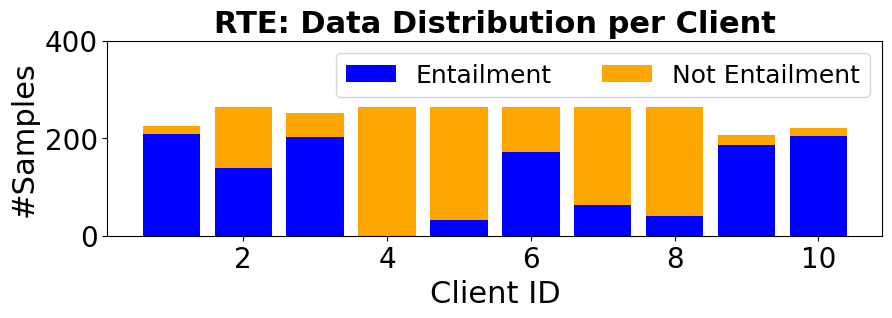

In [65]:
num_clients = 10
alpha = 1.0
name = 'rte'

# Load the raw dataset
raw_datasets = load_dataset(path='glue', name=name)

# 2. Training dataset
raw_train_dataset = raw_datasets['train']

# Calculate the prior distribution
prior_distribution, num_labels = calculate_prior_distribution(raw_train_dataset)

# Partition the dataset into federated datasets
client_datasets = federated_dirichlet_datasets(raw_train_dataset, prior_distribution, num_clients, alpha)

client_label_distr = [
    get_label_distribution(client_datasets[i]) for i in range(num_clients)
]

# Convert data to a DataFrame for easier manipulation
df = pd.DataFrame(client_label_distr)
df = df.fillna(0)


# Save to PDF
pdf = PdfPages(f'plots/RTE_distribution.pdf')

# Create a stacked bar chart for the label distribution across clients
fig, ax = plt.subplots(figsize=(10, 3))
x = range(1, len(df)+1)
ax.bar(x, df['entailment'], label='Entailment', color='blue')
ax.bar(x, df['not_entailment'], bottom=df['entailment'], label='Not Entailment', color='orange')

# Add labels and title
ax.set_title('RTE: Data Distribution per Client')
ax.set_xlabel('Client ID')
ax.set_ylabel('#Samples')
ax.legend()
ax.set_ylim(0, 400)

plt.subplots_adjust(top=0.88, bottom=0.23)  # Adjust these values as needed

legend = ax.legend(ncol=2)

pdf.savefig(plt.gcf()) # Save the current figure
# Display the plot
plt.show()
plt.close()
pdf.close()

## QNLI

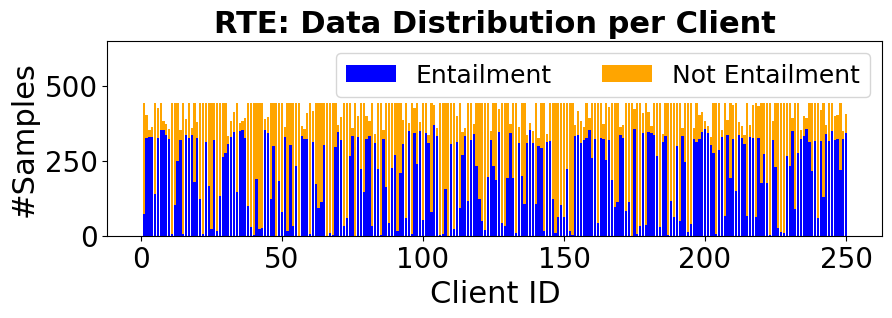

In [66]:
num_clients = 250
alpha = 1.0
name = 'qnli'

np.random.seed(42)
random.seed(42)

# Load the raw dataset
raw_datasets = load_dataset(path='glue', name=name)

# 2. Training dataset
raw_train_dataset = raw_datasets['train']

# Calculate the prior distribution
prior_distribution, num_labels = calculate_prior_distribution(raw_train_dataset)

# Partition the dataset into federated datasets
client_datasets = federated_dirichlet_datasets(raw_train_dataset, prior_distribution, num_clients, alpha)

client_label_distr = [
    get_label_distribution(client_datasets[i]) for i in range(num_clients)
]

# Convert data to a DataFrame for easier manipulation
df = pd.DataFrame(client_label_distr)
df = df.fillna(0)

# Save to PDF
pdf = PdfPages(f'plots/QNLI_distribution.pdf')

# Create a stacked bar chart for the label distribution across clients
fig, ax = plt.subplots(figsize=(10, 3))
x = range(1, len(df)+1)
ax.bar(x, df['entailment'], label='Entailment', color='blue')
ax.bar(x, df['not_entailment'], bottom=df['entailment'], label='Not Entailment', color='orange')

# Add labels and title
ax.set_title('RTE: Data Distribution per Client')
ax.set_xlabel('Client ID')
ax.set_ylabel('#Samples')
ax.legend()
ax.set_ylim(0, 650)

plt.subplots_adjust(top=0.88, bottom=0.23)  # Adjust these values as needed

legend = ax.legend(ncol=2)

pdf.savefig(plt.gcf()) # Save the current figure
# Display the plot
plt.show()
plt.close()
pdf.close()